In [151]:
from stcn import *
import json
from collections import Counter

The STCN has a field schema:translationOfWork. We can use this field to find information about the translations. Using this field we can find 27509 translations. 6103 are from the English

In [152]:

query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX kb: <http://data.bibliotheken.nl/def#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

SELECT * WHERE {

?resource schema:mainEntityOfPage ?mainEntity .
?mainEntity schema:isPartOf <http://data.bibliotheken.nl/id/dataset/stcn>  . 

?resource schema:translationOfWork ?trans .
?trans schema:inLanguage ?orig_language .

}
"""
df = run_query(query)
df.drop_duplicates('resource.value').shape

(26950, 8)

In [3]:
query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX kb: <http://data.bibliotheken.nl/def#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

SELECT * WHERE {

?resource schema:mainEntityOfPage ?mainEntity .
?mainEntity schema:isPartOf <http://data.bibliotheken.nl/id/dataset/stcn>  . 

?resource schema:translationOfWork ?trans .
?trans schema:inLanguage 'en' .

}
"""
df = run_query(query)
df.shape

(6103, 6)

In [4]:
df.drop_duplicates('resource.value').shape

(6103, 6)

In [153]:

query = """

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <http://schema.org/>
PREFIX kb: <http://data.bibliotheken.nl/def#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

SELECT * WHERE {

?resource schema:mainEntityOfPage ?mainEntity .
?mainEntity schema:isPartOf <http://data.bibliotheken.nl/id/dataset/stcn>  . 

?resource schema:translationOfWork ?trans .
?trans schema:inLanguage 'en' .

OPTIONAL {
?resource schema:name ?title . }

OPTIONAL {
?resource schema:inLanguage ?language . }


?resource schema:publication ?publ .

OPTIONAL {
?publ schema:startDate ?publ_year . }

OPTIONAL {
?publ schema:publishedBy ?printer . 
?printer schema:name ?printer_name . 
?printer schema:location ?location_node .
?location_node schema:address ?address .
?address schema:addressLocality ?place . 
}


OPTIONAL {
?resource schema:author ?author_node . 
?author_node schema:author ?author_info .
?author_info  rdfs:label ?author_name . }


OPTIONAL { 
?resource schema:about ?subject .
?subject skos:prefLabel ?subject_label .
} 

}
"""
df = run_query(query)
df.shape


(12679, 34)

In [6]:
# ?publisher schema:location ?location_node .
# ?location_node schema:address ?address .
# ?address schema:addressLocality ?place . 

In [178]:
df.drop_duplicates('resource.value').shape[0]

6103

In [179]:
import numpy as np

topics_dict = dict()


def read_topics():
    topics_dict = dict()
    topics = pd.read_excel('Topics.xlsx')
    for i,row in topics.iterrows():
        topics_dict[ row['topic'] ] = row['group']
    return topics_dict
    

def cluster_subject(subject):
    
    global topics_dict
    
    if not topics_dict:
        topics_dict = read_topics()
    
    if not(pd.isna(subject)):    
        return topics_dict[subject]
    else:
        return np.nan

topics_dict = read_topics()
    
df['subject_cluster'] = df['subject_label.value'].apply(cluster_subject)

## Create JSON

In [205]:
unique_ids = df['resource.value'].unique()

data = []

def print_value(value):
    if pd.isna(value):
        return ''
    else:
        return value
    
def get_values(df,field,fields_dict):
    rows = df.drop_duplicates(field)
    all_rows = []
    for i,row in rows.iterrows():
        values = dict()
        for f in fields_dict:
            values[fields_dict[f]] = print_value(row[f])
        all_rows.append(values)
    return all_rows    

for resource in unique_ids:
    record = dict()
    record['ppn'] = resource
    #print(resource)

    df_resource = df[ df['resource.value'] == resource ]
    
    record['title'] = df_resource.iloc[0]['title.value']
    record['year'] = print_value(df_resource.iloc[0]['publ_year.value'])
    
    ## Publishers
    unique_id = 'printer.value'
    fields_dict = { 'printer.value':'ppn',
        'printer_name.value':'name',
        'place.value':'place'
    }
    all_publishers = get_values(df_resource,unique_id,fields_dict)
    record['publishers'] = all_publishers

    ## Subjects
    unique_id = 'subject.value'
    fields_dict = {'subject.value':'ppn',
              'subject_label.value':'label',
               'subject_cluster':'group' }
    all_subjects = get_values(df_resource,unique_id,fields_dict)
    record['subjects'] = all_subjects
    
    ## Authors
    unique_id = 'author_info.value'
    fields_dict = {'author_info.value':'ppn',
              'author_name.value':'name' }
    all_authors = get_values(df_resource,unique_id,fields_dict)
    record['authors'] = all_authors
    
    ## Languages
    unique_id = 'language.value'
    fields_dict = {'language.value':'code' }
    all_languages = get_values(df_resource,unique_id,fields_dict)
    record['languages'] = all_languages
    
    data.append(record)
    
with open('translations.json','w',encoding='utf-8') as out:
    out.write(json.dumps(data,indent=4))

In [206]:
f = open('translations.json')
json_data = json.load(f)
f.close()

## Languages

In [227]:
language_freq = Counter()

for book in json_data:
    for language in book['languages']:
        #print(language)
        language_freq.update([language['code']])
        
for language,count in language_freq.most_common(len(language_freq)):
    print(language)
    print(f'{Lang(language).name},{count}')
        

nl
Dutch,4656
fr
French,1239
la
Latin,162
de
German,65
en
English,41
pl
Polish,4
it
Italian,4
he
Hebrew,2
es
Spanish,1
hu
Hungarian,1
da
Danish,1
ms
Malay (macrolanguage),1


## Comparison with Schooneveld's list

In [247]:
c17 = []

for book in json_data:
    
    ## establish year
    year = ''
    if re.search( r'\d{4}' , str(book['year']) ):
        year = int(book['year'])
    elif re.search( r'\d{2}xx' , str(book['year']) , re.IGNORECASE ):
        year = int(book['year'][:2] + str(50))
    else:
        year = 9999
        
    language = 'xx'
    for lang in book['languages']:
        if lang['code'] == 'nl':
            language = 'nl'
    
    if year>1600 and year<1701:
        c17.append( language + ' '+ str(year) + ' ' + book['title']+' '+book['ppn']+ ' '+ book['authors'][0]['name'] + ' '+ book['subjects'][0]['group'])

print(f'{len(c17)} in total')
        
count = 0
for title in c17:
    if re.search( '^nl' , title):
        count += 1
        
print(f'{count} titles into Dutch')
        

2544 in total
2174 titles into Dutch


## Publishers

In [13]:
publisher_freq = Counter()

for book in json_data:
    publisher_name = ''
    for publisher in book['publishers']:
        publisher_name += publisher['name'] + '; '
    publisher_name = re.sub( r';\s+$' , '' , str(publisher_name) )
    publisher_freq.update([publisher_name])
    
print(f'{len(publisher_freq)} publishers')

for name,i in publisher_freq.most_common(50):
    print(f"{name} {i}")

1708 publishers
 512
s.n. 263
Aa, Pieter van der (I) 122
Arkstee, Johann Caspar; Merkus, Henricus; Merkus, Henricus; Arkstee, Johann Caspar 75
Broersz, Joost 71
Douci Pietersz, Adriaan; Pelt, Hendrik van 64
Swart, Steven (wed.) 58
Loveringh, Jacobus; Tirion, Isaak 53
Tirion, Isaak 52
Cloppenburgh, Jan Evertsz (II) 48
Meyer, Pieter 45
Boekholt, Johannes 37
Bos, Barent 36
Bruyn, Martinus de 34
s.n.; s.n. 31
Someren, Joannes van 28
Uytwerf, Hermannus 27
Boitet, Reinier 25
Boxe, Willem Christiaens van der 22
Broun, Samuel 22
Claus, Jacob 22
Wetstein, Rudolf; Wetstein, Gerard 22
Linden, Dirk onder de; Linden, Gerard Adriaan onder de 21
Scheurleer, Hendrik 21
Hondt, Pieter de 21
Esveldt, Steven van 21
Schilders, Richard 20
Cloeting, Jan Andriesz 20
Doesburg, Reinier van 20
Tongerlo, Kornelis van (I) 20
Besseling, Hermanus 20
Acher, Abraham 19
Meuris, Aert 19
Baalde, Steven Jacobus 19
Humbert, Pierre 19
Yntema, Jacob; Tieboel, Jacob 19
Wetstein, Henricus 18
Warnars, Gerrit; Meyer, Pieter (erv

In [187]:
count = 0
authors = dict()
languages = dict()

regex_publisher_name = 'Aa'

for book in json_data:
    
    publisher_name = ''
    
    for publisher in book['publishers']:
        publisher_name += publisher['name'] + '; '
    
    if re.search( regex_publisher_name , publisher_name ):

        print( book['ppn'])
        print( book['title'] , end = '')
        print( f" ({book['year']})" )
        for author in book['authors']:
            print(author['name'])
            authors[author['name']] = authors.get(author['name'],0)+1
            if author['name'].strip() == 'Steele, R. (1672-1729)':
                count += 1
        for subject in book['subjects']:
            print(subject['label'] , end = ' -- ')
        for lang in book['languages']:
            print(lang['code'] , end = ' -- ')
            languages[lang['code']] = languages.get(lang['code'],0)+1
        print('\n')

print(count)

print(authors)
print(languages)

http://data.bibliotheken.nl/id/nbt/p842902449
Een verhaal van den handel op Oost-Indien, beneffens den staat der tegenwoordige Compagnie. (1692)
White, George
History (Great Britain and Ireland) -- History (Asia) -- nl -- 

http://data.bibliotheken.nl/id/nbt/p843276150
De bloedige vierschaar, of een volkomene history van het leven en bedryf van George Lord Jefferies. (1689)
Bent, James (1685 fl.)
History (Great Britain and Ireland) -- nl -- 

http://data.bibliotheken.nl/id/nbt/p843285109
Een brief van den bisschop van Rochester aen den zeer eerwaerdigen graef van Dorset [...]. Wegens zyne zittinge in de gewesene kerckelycke commissie. (1689)
Sprat, Thomas (1635-1713)
History (Great Britain and Ireland) -- nl -- 

http://data.bibliotheken.nl/id/nbt/p844147893
Een naukeurigh ondersoeck nopende de tegenwoordige gesteltheyt van saken. (1689)
Burnet, Gilbert (1643-1715)
History (Great Britain and Ireland) -- nl -- 

http://data.bibliotheken.nl/id/nbt/p844148040
De leere van passive gehoorsa

## Years

In [184]:
years_count = Counter()

for book in json_data:
    if re.search( r'\d{4}' , book['year']):
        years_count.update([ book['year'] ])

for y,c in years_count.most_common():
    print(f"{y} {c}")

1688 186
1649 109
1643 84
1642 83
1689 74
1742 69
1706 66
1768 58
1779 57
1712 56
1685 54
1767 54
1745 54
1770 54
1659 52
1744 51
1773 50
1696 47
1781 47
1750 47
1660 46
1657 46
1777 46
1735 46
1690 45
1673 45
1765 45
1730 45
1764 45
1778 43
1769 43
1780 43
1738 43
1763 43
1661 42
1775 42
1687 41
1776 41
1759 41
1727 41
1715 41
1740 41
1701 40
1756 40
1746 40
1741 40
1743 40
1707 40
1772 40
1658 39
1695 39
1782 39
1752 39
1656 38
1641 38
1791 38
1793 38
1679 37
1771 36
1754 36
1747 36
1700 35
1761 35
1762 35
1748 35
1603 34
1644 34
1652 34
1653 34
1766 34
1648 33
1774 33
1698 32
1704 32
1729 32
1645 31
1654 31
1783 31
1733 31
1794 31
1639 30
1662 30
1758 30
1739 30
1734 30
1749 30
1721 30
1655 29
1678 29
1692 29
1669 29
1755 29
1757 29
1790 28
1792 28
1702 27
1751 27
1736 27
1674 26
1788 26
1787 26
1681 25
1665 25
1691 25
1728 25
1725 25
1718 25
1624 24
1621 24
1651 24
1714 24
1732 24
1737 24
1646 23
1672 23
1693 23
1694 23
1753 23
1711 23
1668 22
1604 22
1650 22
1784 22
1713 22
1716 2

In [124]:
## Average

print(int(min(list(years_count.keys()))))
print(int(max(list(years_count.keys()))))

period = int(max(list(years_count.keys()))) - int(min(list(years_count.keys())))
books = sum(list(years_count.values()))
print(books/period)

1543
1850
19.156351791530945


In [16]:
for year,count in years_count.most_common(10):
    print(f'{year} {count}')

1688 186
1649 109
1643 84
1642 83
1689 74
1742 69
1706 66
1768 58
1779 57
1712 56


In [185]:
for book in json_data:
    if book['year'] == '1688':
        print(book['ppn'])
        print(book['title'] , end = '\n\n')


http://data.bibliotheken.nl/id/nbt/p830703063
Aenmerkinge op het geschrift, genaemt Parlamentum pacificum.

http://data.bibliotheken.nl/id/nbt/p830863001
Redenen voor het afstellen en vernietigen van de Test, al de leden van het parlement opgeleght anno 1678. 30. october.

http://data.bibliotheken.nl/id/nbt/p832685380
Drie brieven wegens den tegenwoordigen toestand van Italie, geschreeven in't jaar 1687.

http://data.bibliotheken.nl/id/nbt/p841327432
Derde declaratie van den heere prince van Oranje.

http://data.bibliotheken.nl/id/nbt/p841327491
Derde declaratie van den heere prince van Oranje.

http://data.bibliotheken.nl/id/nbt/p841775761
L'Amerique angloise, ou Description des isles et terres du roi d'Angleterre, dans l'Amerique.

http://data.bibliotheken.nl/id/nbt/p840636911
Verscheyde brieven en extracten, nevens de generale associatie van de edelluyden van Devonshire, aen sijne hoogheyd den prince van Orangie

http://data.bibliotheken.nl/id/nbt/p840636970
Missive van den koningh 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


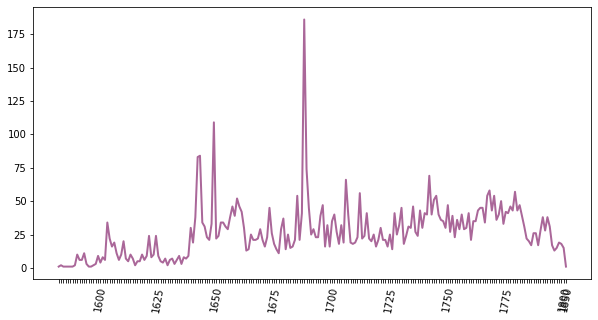

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

x_axis = sorted(years_count.keys())
y_axis = []
x_labels = []
for year in x_axis:
    y_axis.append( years_count.get(year) )
    if int(year) % 25 == 0:
        x_labels.append(year)
    else:
        x_labels.append('')


fig = plt.figure( figsize = ( 10, 5))
ax = sns.lineplot(x= x_axis, y=y_axis, 
                  color= '#AA6799', linestyle='solid',linewidth=2 )


ax.set_xticklabels(x_labels)

plt.xticks(rotation= 80)
plt.show()

## Subjects

In [146]:
subjects_freq = Counter()

for book in json_data:
    languages = ''
    for lang in book['languages']:
        languages += lang['code'] + ' '
        
    if re.search(r'\bnl\b' , languages):
    #if 2<3:
        for subject in book['subjects']:
            subjects_freq.update([subject['group']])
            

History 39.39
Theology 35.06
Political science and economics 5.93
Geography 5.54
Language and literature 5.51
Other 2.47
Science 2.1
Medicine 1.68
 1.16
Biology 0.52
Law 0.4
Arts 0.13
Geology 0.08
Psychology 0.02


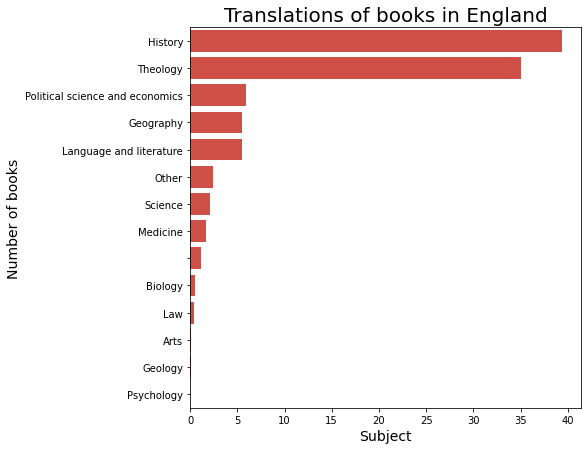

In [148]:
fig = plt.figure( figsize=( 7 , 7 ) )

x_axis = []
y_axis = []

total = sum(subjects_freq.values())
for subject, count in subjects_freq.most_common():
    y_axis.append(subject)
    percentage = round(((count/total)*100),2)
    x_axis.append( percentage  )
    print(subject , percentage)




graph = sns.barplot( y= y_axis , x= x_axis ,  dodge=False , color = '#e63c30' )

graph.set_title('Translations of books in England' , size = 20) 
graph.set_xlabel('Subject' , size = 14) 
graph.set_ylabel('Number of books' , size = 14 )

plt.show()

## Authors

In [81]:
author_count = Counter()

for book in json_data:
    for author in book['authors']:
        author_count.update( [author['name'] ] )
    

In [221]:
for author,count in author_count.most_common():
    print(f"{author} {count}")

 22
Boyle, Robert (1627-1691 ; natuur- en scheikundige) 13
Derham, William (1657-1735) 13
Cuthbertson, Jonathan (1744-1806) 9
Baker, Henry (1698-1774 ; natuurhistoricus) 5
Lilly, William (1602-1681) 4
Priestley, Jos. (1733-1804) 4
Martin, Benjamin (1704-1782) 3
Ingenhousz, Jan (1730-1799) 3
Burdon, William (18de eeuw) 3
Desaguliers, J.T. (1683-1744) 3
Potter, Francis (1594-1678) 2
Digby, Kenelm (Sir ; 1603-1665) 2
Bourne, William (-1583) 2
Starkey, George (1627-1665) 2
Swift, Jonathan (1667-1745) 2
Telescope, Tom. (A.M.) 2
Fleming, Rob. (1660-1716) 2
Smith, Robert (1689-1768) 2
Hales, Stephen (1677-1761) 2
Magalhães, João Jacinto de (1722-1790) 2
Taylor, Brook (1685-1731) 2
Cotes, Roger (1682-1716) 2
Watts, Isaac (1674-1748 ; dichter (o.a. kindergedichten)) 2
Adams, George (1750-1795) 2
Michelot, Henri (1709-1730 fl.) 2
Gee, Joshua (1698-1748) 2
Fitzgerald, Robert (ca 1680) 1
Hardy, George 1
Partridge, John (1644-1715) 1
Gerbier, Balthasar (1592-1663) 1
Anderson, John (1726-1796) 1
Vau

In [122]:
regex_author_name = 'Boyle, Robert'
languages = dict()
years = []
ppn = dict()
titles = []

count = 0

for book in json_data:
    author_name = ''
    for author in book['authors']:
        author_name += author['name'] + '; '

    if re.search(regex_author_name,author_name):
        count += 1
        print( f"{count}. " , end = '')
        print( book['ppn'])
        ppn[book['ppn']] = ppn.get(book['ppn'],0)+1
        print( book['title'] , end = '')
        titles.append(book['title'])
        print( f" ({book['year']})" )
        years.append(book['year'])
        
        authors = ''
        for author in book['authors']:
            authors += author['name'].strip() + '; ' 
        print(authors)
        
        for publisher in book['publishers']:
            publ_name + publisher['name'] + '; '
        print(publ_name)
            
        subjects = ''
        for subject in book['subjects']:
            subjects += subject['group']
        print(subjects)
        
        all_languages = ''
        for lang in book['languages']:
            all_languages += lang['code']
            languages[lang['code']] = languages.get(lang['code'],0)+1
        print(all_languages)
        print('\n')
        
print(languages)
print(len(ppn))
print(sorted(years))
print(sorted(set(titles)))

1. http://data.bibliotheken.nl/id/nbt/p850597382
Tentamina qvædam physiologica diversis temporibus & occasionibus conscripta. (1667)
Boyle, Robert (1627-1691 ; natuur- en scheikundige); 

Science
la


2. http://data.bibliotheken.nl/id/nbt/p058040420
Chymista scepticus vel Dubia et paradoxa chymico-physica, circa spagyricorum principia. (1668)
Boyle, Robert (1627-1691 ; natuur- en scheikundige); 

ScienceScience
la


3. http://data.bibliotheken.nl/id/nbt/p100097502
Onderzoek wegens de eynd-oorzaaken der natuurlyke dingen. (1688)
Boyle, Robert (1627-1691 ; natuur- en scheikundige); 

Other
nl


4. http://data.bibliotheken.nl/id/nbt/p09492516X
Tentamina, quædam physiologica. Diversis temporibus, & occasionibus conscripta. (1667)
Boyle, Robert (1627-1691 ; natuur- en scheikundige); 

Science
la


5. http://data.bibliotheken.nl/id/nbt/p094925801
Historia fluiditatis et firmitatis. (1667)
Boyle, Robert (1627-1691 ; natuur- en scheikundige); 

Science
la


6. http://data.bibliotheken.nl/id/nb

In [111]:
author_count = Counter()

for book in json_data:
    subjects = []
    for subject in book['subjects']:
        subjects.append(subject['group'])
    if 'Science' in subjects:
        for author in book['authors']:
            author_count.update( [author['name'] ] )
    

In [112]:
for author,count in author_count.most_common(50):
    print(f"{author} {count}")

 22
Boyle, Robert (1627-1691 ; natuur- en scheikundige) 13
Derham, William (1657-1735) 13
Cuthbertson, Jonathan (1744-1806) 9
Baker, Henry (1698-1774 ; natuurhistoricus) 5
Lilly, William (1602-1681) 4
Priestley, Jos. (1733-1804) 4
Martin, Benjamin (1704-1782) 3
Ingenhousz, Jan (1730-1799) 3
Burdon, William (18de eeuw) 3
Desaguliers, J.T. (1683-1744) 3
Potter, Francis (1594-1678) 2
Digby, Kenelm (Sir ; 1603-1665) 2
Bourne, William (-1583) 2
Starkey, George (1627-1665) 2
Swift, Jonathan (1667-1745) 2
Telescope, Tom. (A.M.) 2
Fleming, Rob. (1660-1716) 2
Smith, Robert (1689-1768) 2
Hales, Stephen (1677-1761) 2
Magalhães, João Jacinto de (1722-1790) 2
Taylor, Brook (1685-1731) 2
Cotes, Roger (1682-1716) 2
Watts, Isaac (1674-1748 ; dichter (o.a. kindergedichten)) 2
Adams, George (1750-1795) 2
Michelot, Henri (1709-1730 fl.) 2
Gee, Joshua (1698-1748) 2
Fitzgerald, Robert (ca 1680) 1
Hardy, George 1
Partridge, John (1644-1715) 1
Gerbier, Balthasar (1592-1663) 1
Anderson, John (1726-1796) 1
Vau

Hoftijzer mentions books written by Francis Bacons The advancement of learning (1605), and Novum organum (1620). William Harvey's De motu cordis (Frankfurt 1628) and the Latin publications by Robert Boyle , published in the Low Countries, but also Isaac Newtons Philosophiae naturalis principia mathematica (Londen 1687).

In [25]:
## Francis Bacon: "
#http://data.bibliotheken.nl/doc/thes/p068482817"
#http://data.bibliotheken.nl/id/thes/p068482817   
#http://data.bibliotheken.nl/doc/thes/p068482817

In [26]:
author_ppn = "http://data.bibliotheken.nl/id/thes/p068482817"
count = 0

for book in json_data:
    for author in book['authors']:
        if author['ppn'] == author_ppn:
            count += 1
            print( book['title'] )
            print( book['year'] )
            for pr in book['publishers']:
                print(pr['name'])
            print('')
print(count)

Historia regni Henrici Septimi Angliæ regis.
1642
Hackius, Franciscus

Politiicke ende andere deftige bedenckingen geschreven [...] by den grooten cancelier van Engelandt.
1649
Banheyning, Cornelis

Sermones fideles, ethici, politici, œconomici: sive Interiora rerum.
1644
Hackius, Franciscus

Nieuwen atlas, ofte Beschrijvinge van het noyt meer gevonden eylandt van Bensalem.
1656
Vries, Nicolaes de
Andriessz, Abraham

Nova Atlantis.
1643


Historia regni Henrici Septimi Angliæ regis.
1662
Elzevier, Daniel
Elzevier, Lowijs (III)

Sermones fideles, ethici, politici, œconomici: sive Interiora rerum.
1662
Elzevier, Daniel
Elzevier, Lowijs (III)

Sylva sylvarvm, sive Hist. natvralis.
1661
Elzevier, Daniel
Elzevier, Lowijs (III)

Sylva sylvarvm, sive Hist. natvralis.
1648
Elzevier, Lowijs (III)

Sermones fideles, ethici, politici, œconomici: sive Interiora rerum.
1644
Hackius, Franciscus

Sermones fideles, ethici, politici, œconomici.
1659
Hackius, Franciscus

Sylva sylvarum, sive Hist. natvr

In [157]:
## Network Analysis

In [177]:
edges = open('translations_edges.csv','w')
nodes = open('translations_nodes.csv','w')

all_authors = dict()
all_publishers = dict()


edges.write('Source,Target,Type\n')
nodes.write('Id,Label,Type\n')

for book in json_data:
    authors = []
    publishers = []
    for author in book['authors']:
        authors.append(os.path.basename(author['ppn']))
        all_authors[author['ppn']] = author['name']
    for publisher in book['publishers']:
        #print(os.path.basename(author['ppn']))
        publishers.append(os.path.basename(publisher['ppn']))
        all_publishers[publisher['ppn']] = publisher['name']
    for author in authors:
        for publisher in publishers:
            edges.write( f'{author},{publisher},Undirected\n')
    
for node in all_authors:
    name = all_authors[node]
    if re.search( '\(' , name):
        name = name[:name.index('(')].strip()        
    nodes.write(f'{os.path.basename(node)},"{name}",Author\n')
    
    
for node in all_publishers:
    name = all_publishers[node]
    if re.search( '\(' , name):
        name = name[:name.index('(')].strip()  
    nodes.write(f'{os.path.basename(node)},"{name}",Publisher\n')

In [27]:
from collections import Counter
unique_ids = df['resource.value'].unique()
publ_freq = Counter()

for resource in unique_ids:
    df_resource = df[ df['resource.value'] == resource ]
    publishers = df_resource.drop_duplicates('printer_name.value')
    imprint = ''
    if publishers.shape[0] > 1:
        print(publishers['printer_name.value'])
    for p in publishers['printer_name.value']:
        imprint += str(p) + '; '
    imprint = re.sub( r';$' , '' , str(imprint).strip() )
    publ_freq.update([imprint])

13    Andriessz, Abraham
14       Neering, Gillis
Name: printer_name.value, dtype: object
23    Hellen, Hans van der
24    Vivere, Jacob van de
Name: printer_name.value, dtype: object
53    La Tombe, Desiderius de
54          Meester, Jacob de
Name: printer_name.value, dtype: object
79                                s.n.
80    Boxe, Willem Christiaens van der
Name: printer_name.value, dtype: object
83    Linde, Simon onder de
84       Vlieger, Petrus de
Name: printer_name.value, dtype: object
119                    Ribbius, Hermannus (I)
120    Janssonius van Waesberge, Johannes (I)
Name: printer_name.value, dtype: object
121        Versteegh, Henrick
122    Ribbius, Hermannus (I)
Name: printer_name.value, dtype: object
144           Basson, Thomas
145    Plantijn, Christoffel
Name: printer_name.value, dtype: object
147    Andriessz, Abraham
148       Neering, Gillis
Name: printer_name.value, dtype: object
153              Geervliet, Abraham van
154    Boxe, Willem Christiaens van der


Name: printer_name.value, dtype: object
914    Boom, Jan Hendricksz
915       Lier, Steeven van
916     Rieuwertsz, Jan (I)
Name: printer_name.value, dtype: object
919    Bruyningh, Joseph (wed.)
920               Swart, Steven
Name: printer_name.value, dtype: object
936    Boom, Jan Hendricksz
937     Rieuwertsz, Jan (I)
Name: printer_name.value, dtype: object
938    Elzevier, Lowijs (III)
939          Royston, Richard
940            Barker, Robert
941                      M.B.
942        Gellibrand, Samuel
943              Smith, Ralph
Name: printer_name.value, dtype: object
944    Elzevier, Lowijs (III)
945                      s.n.
Name: printer_name.value, dtype: object
948    Elzevier, Lowijs (III)
949          Royston, Richard
950        Gellibrand, Samuel
951              Smith, Ralph
Name: printer_name.value, dtype: object
952    Elzevier, Lowijs (III)
953            Barker, Robert
Name: printer_name.value, dtype: object
956     Claesz, Cornelis
957    Chorlton, Jeffrey
Name: 

Name: printer_name.value, dtype: object
2164    Schipper, Jan Jacobsz
2165    Stam, Jan Fredericksz
Name: printer_name.value, dtype: object
2168      Bruyn, Cornelis de
2169    Kuypen, Jan Pietersz
Name: printer_name.value, dtype: object
2170           Back, Ernestus
2171    Cunradus, Christoffel
Name: printer_name.value, dtype: object
2172        Jochems, Schelte
2173    Someren, Joannes van
Name: printer_name.value, dtype: object
2174    Boom, Jan Hendricksz
2175     Rieuwertsz, Jan (I)
Name: printer_name.value, dtype: object
2176    Boeteman, Pieter Dircksz
2177        Someren, Joannes van
Name: printer_name.value, dtype: object
2181    Borstius, Gerardus (I)
2182            Rampen, Herman
Name: printer_name.value, dtype: object
2198    Brandt, Marten Jansz (wed.)
2199         Burgh, Abraham van den
Name: printer_name.value, dtype: object
2209           Elzevier, Daniel
2210    Ravesteyn, Johannes van
Name: printer_name.value, dtype: object
2212       Bakkamude, Daniel
2213    Somer

Name: printer_name.value, dtype: object
2828    Norton, Bonham
2829    Bill, John (I)
Name: printer_name.value, dtype: object
2842     Field, John
2843    Hills, Henry
Name: printer_name.value, dtype: object
2871    Baron, Jan Zachariasz
2872       Verbiest, Hendrick
Name: printer_name.value, dtype: object
2898    Blussé, Abraham
2899     Blussé, Pieter
Name: printer_name.value, dtype: object
2907    Brandt, Marten Jansz
2908    Hellen, Hans van der
Name: printer_name.value, dtype: object
2910          Benjamin, Jacob
2911    Cunradus, Christoffel
Name: printer_name.value, dtype: object
2913    Burgh, Abraham van den
2914         Matthysz, Severyn
Name: printer_name.value, dtype: object
2928     Blom, Joannes
2929    Karstensz, Jan
Name: printer_name.value, dtype: object
2932    Vries, Nicolaes de
2933    Andriessz, Abraham
Name: printer_name.value, dtype: object
2935    Andriessz, Abraham
2936          Braat, Jacob
Name: printer_name.value, dtype: object
2937    Vries, Nicolaes de
2

Name: printer_name.value, dtype: object
3914     Wetstein, Rudolf
3915       Smith, William
3916    Wetstein, Jacobus
Name: printer_name.value, dtype: object
3917    Arkstee, Johann Caspar
3918          Merkus, Henricus
Name: printer_name.value, dtype: object
3921       Smith, William
3922    Wetstein, Jacobus
Name: printer_name.value, dtype: object
3923       Smith, William
3924    Wetstein, Jacobus
Name: printer_name.value, dtype: object
3925    Arkstee, Johann Caspar
3926          Merkus, Henricus
Name: printer_name.value, dtype: object
3929    Arkstee, Johann Caspar
3930          Merkus, Henricus
Name: printer_name.value, dtype: object
3933    Arkstee, Johann Caspar
3934          Merkus, Henricus
Name: printer_name.value, dtype: object
3937    Arkstee, Johann Caspar
3938          Merkus, Henricus
Name: printer_name.value, dtype: object
3970             Allart, Johannes
3971    Loveringh, Jacobus (wed.)
Name: printer_name.value, dtype: object
3975     Vries, Nicolaes de
3976    Geer

Name: printer_name.value, dtype: object
5029    Bernard, Jean Frederic
5030           Humbert, Pierre
Name: printer_name.value, dtype: object
5038               Holtrop, Willem
5039    Esveldt, Steven van (wed.)
Name: printer_name.value, dtype: object
5043      Broedelet, Johannes
5044    Muntendam, Pieter (I)
Name: printer_name.value, dtype: object
5048    Blussé, Abraham
5049     Blussé, Pieter
Name: printer_name.value, dtype: object
5054    Huyssteen, Arend van
5055        Lubeek, Koenraat
Name: printer_name.value, dtype: object
5060    Boeteman, Pieter Dircksz
5061            La Burgh, Pieter
5062        Someren, Joannes van
Name: printer_name.value, dtype: object
5072                  Janssonius van Waesberge, Maria
5073                Janssonius van Waesberge, Hendrik
5074    Janssonius van Waesberge, Johannes (II, wed.)
5075         Janssonius van Waesberge, Johannes (III)
Name: printer_name.value, dtype: object
5079         L'Honoré, François
5080    Chatelain, Zacharias (I

Name: printer_name.value, dtype: object
5601                       s.n.
5602    Moutard, Nicolas-Léger
Name: printer_name.value, dtype: object
5603    Duren, Johannes van (I)
5604     Moetjens, Adriaen (II)
Name: printer_name.value, dtype: object
5606    Gosse, Pierre
5607    Neaulme, Jean
Name: printer_name.value, dtype: object
5608    Gosse junior, Pierre
5609           Pinet, Daniel
Name: printer_name.value, dtype: object
5617           Warnars, Gerrit
5618       Eyk, Pieter van der
5619          Groot, Gerrit de
5620       Luchtmans, Johannes
5621    Luchtmans, Samuel (II)
5622          Schouten, Petrus
5623             Groot, Jan de
Name: printer_name.value, dtype: object
5627    Gosse, Pierre
5628    Neaulme, Jean
Name: printer_name.value, dtype: object
5631                          s.n.
5632                 Desaint, Jean
5633             Saillant, Charles
5634    Panckoucke, Charles-Joseph
5635         Pissot, Noël-Jacques
5636          Nyon, Jean-Luc (III)
Name: printer_name.

Name: printer_name.value, dtype: object
6364               s.n.
6366    Darres, William
Name: printer_name.value, dtype: object
6369    Steenhouwer, Josua
6370    Uytwerf, Hermannus
Name: printer_name.value, dtype: object
6371    Steenhouwer, Josua
6372    Uytwerf, Hermannus
Name: printer_name.value, dtype: object
6374    Gosse, Pierre Frederik
6375         Hindmarsh, Robert
Name: printer_name.value, dtype: object
6398          Benjamin, Jacob
6399    Cunradus, Christoffel
Name: printer_name.value, dtype: object
6403    Blussé, Abraham
6404     Blussé, Pieter
Name: printer_name.value, dtype: object
6433          Bennet, Lambert
6434    Hake, Charles Richard
Name: printer_name.value, dtype: object
6436          Bennet, Lambert
6437    Hake, Charles Richard
Name: printer_name.value, dtype: object
6438          Thol, Ottho van
6439    Thol, Pieter van (II)
Name: printer_name.value, dtype: object
6440    Thol, Ottho van (wed.)
6441     Thol, Pieter van (II)
6442    Thol, Pieter van (III)

Name: printer_name.value, dtype: object
6956      Vis, Dirk (II)
6957    Holsteyn, Pieter
Name: printer_name.value, dtype: object
6958      Vis, Dirk (II)
6959    Holsteyn, Pieter
Name: printer_name.value, dtype: object
6960      Vis, Dirk (II)
6961    Holsteyn, Pieter
Name: printer_name.value, dtype: object
6962      Vis, Dirk (II)
6963    Holsteyn, Pieter
Name: printer_name.value, dtype: object
6964      Vis, Dirk (II)
6965    Holsteyn, Pieter
Name: printer_name.value, dtype: object
6966      Vis, Dirk (II)
6967    Holsteyn, Pieter
Name: printer_name.value, dtype: object
6972    Dole, Antoine van
6973    Groot, Anthoni de
Name: printer_name.value, dtype: object
6974                    s.n.
6976    Vlaenderen, Jean van
Name: printer_name.value, dtype: object
6979      Vis, Dirk (II)
6980    Bothall, Abraham
6981    Holsteyn, Pieter
Name: printer_name.value, dtype: object
6983       Luchtmans, Johannes
6984    Luchtmans, Samuel (II)
Name: printer_name.value, dtype: object
6986         

Name: printer_name.value, dtype: object
7478                s.n.
7481    Rey, Marc Michel
Name: printer_name.value, dtype: object
7485     Yntema, Jacob
7486    Tieboel, Jacob
Name: printer_name.value, dtype: object
7512    Covens, Johannes (I)
7513       Mortier, Cornelis
Name: printer_name.value, dtype: object
7533            Holtrop, Willem
7534    Paddenburg, Abraham van
7535       Aa, Cornelis van der
Name: printer_name.value, dtype: object
7538    Hondt, Pieter de
7539         Vos, Pieter
Name: printer_name.value, dtype: object
7540    Hondt, Pieter de
7541         Vos, Pieter
Name: printer_name.value, dtype: object
7542    Hondt, Pieter de
7543         Vos, Pieter
Name: printer_name.value, dtype: object
7544    Hondt, Pieter de
7545         Vos, Pieter
Name: printer_name.value, dtype: object
7547    Hondt, Pieter de
7548         Vos, Pieter
Name: printer_name.value, dtype: object
7549    Hondt, Pieter de
7550         Vos, Pieter
Name: printer_name.value, dtype: object
7551    Ho

Name: printer_name.value, dtype: object
8103           Enschedé, Izaak
8104    Enschedé, Johannes (I)
Name: printer_name.value, dtype: object
8105           s.n.
8106    Luzac, Elie
Name: printer_name.value, dtype: object
8112                  Braat, Jacob
8113    Snellaert, Esdras Willemsz
8114        Ribbius, Hermannus (I)
Name: printer_name.value, dtype: object
8117    Boom, Dirk (I, wed.)
8118          Boom, Hendrick
Name: printer_name.value, dtype: object
8120     Gartman, Hendrik
8121     Smit, Jan Willem
8122    Vermandel, Willem
Name: printer_name.value, dtype: object
8135    Cloppenburgh, Jan Evertsz (II)
8136                    Rooman, Gillis
Name: printer_name.value, dtype: object
8137    Cloppenburgh, Jan Evertsz (II)
8138                    Rooman, Gillis
Name: printer_name.value, dtype: object
8150       Ravesteyn, Nicolaes van
8151    Snellaert, Esdras Willemsz
Name: printer_name.value, dtype: object
8152    Groot, Gijsbert de (wed.)
8155                         s.n.
N

Name: printer_name.value, dtype: object
8747           Yntema, Jacob
8748          Tieboel, Jacob
8749    Kroe, Albert van der
8750      Kruyff, Fredrik de
Name: printer_name.value, dtype: object
8762                           Dam, Anthony van
8763    Groot, Gijsbert de (wed., erven van de)
Name: printer_name.value, dtype: object
8764    Tongerlo, Kornelis van (I)
8765               Houttuyn, Frans
Name: printer_name.value, dtype: object
8767              Claus, Jacob
8768    Wijnbrugge, Pieter van
Name: printer_name.value, dtype: object
8770      Vis, Dirk (II)
8771    Bothall, Abraham
8772    Holsteyn, Pieter
Name: printer_name.value, dtype: object
8785                           Dam, Anthony van
8788    Groot, Gijsbert de (wed., erven van de)
Name: printer_name.value, dtype: object
8795                           Dam, Anthony van
8796    Groot, Gijsbert de (wed., erven van de)
Name: printer_name.value, dtype: object
8807              s.n.
8808    Merlin, Joseph
Name: printer_name.valu

9431    Vries, Nicolaes de
9432    Andriessz, Abraham
Name: printer_name.value, dtype: object
9434    Bruyn, Johannis de
9435       Vlugt, Dirk. de
Name: printer_name.value, dtype: object
9476    Vries, Lucas Simonsz de
9477            Vries, Simon de
Name: printer_name.value, dtype: object
9486               Byl, Nicolaas
9487     Hasebroek, Johannes (I)
9488    Hasebroek, Johannes (II)
Name: printer_name.value, dtype: object
9493      Borstius, Gerardus (II)
9494               Kuyper, Willem
9495    Eyl Hendrikszoon, Jan van
9496     Gerrevink, Bernardus van
9497           Loveringh, Jacobus
9498                Tirion, Isaak
9499             Vieroot, Hendrik
9500                 Wor, Adriaan
Name: printer_name.value, dtype: object
9501    Tongerlo, Kornelis van (I)
9502               Houttuyn, Frans
Name: printer_name.value, dtype: object
9510    Arkstee, Johann Caspar
9511          Merkus, Henricus
Name: printer_name.value, dtype: object
9514              Yntema, Jacob
9515         

10057    Arkstee, Johann Caspar
10058          Merkus, Henricus
Name: printer_name.value, dtype: object
10080    Blussé, Abraham
10081     Blussé, Pieter
Name: printer_name.value, dtype: object
10115              Yntema, Jacob
10116             Tieboel, Jacob
10117    Plaats, Folkert van der
10118    Plaats, Volkert van der
Name: printer_name.value, dtype: object
10123    Dole, Henry van
10124    Dole, Louis van
Name: printer_name.value, dtype: object
10125    Dole, Henry van
10126    Dole, Louis van
Name: printer_name.value, dtype: object
10132    Changuion, Daniel Jean
10133           Dufour, Gabriel
Name: printer_name.value, dtype: object
10137            Schouten, Petrus
10138    Schouten, Salomon (wed.)
Name: printer_name.value, dtype: object
10140     Beman, Jan Daniel
10141        Bosch, Jacobus
10142      Burgvliet, Jacob
10143    Kentlink, Hermanus
10144        Losel, Jakobus
10145      Losel, Philippus
10146     Smithof, Nikolaes
Name: printer_name.value, dtype: object
1015

10773            s.n.
10774    Stephens, J.
Name: printer_name.value, dtype: object
10787    Wetstein, Rudolf
10788    Wetstein, Gerard
Name: printer_name.value, dtype: object
10794         Wild, Bartholomeus
10795    Houttuyn, Frans (erven)
10796            Bennet, Lambert
10797           Cleef, Isaac van
10798     Damme, Jan Hendrik van
10799      Hake, Charles Richard
10800                Luzac, Elie
Name: printer_name.value, dtype: object
10805          Damme, Andries van
10806    Ratelband, Johannes (II)
Name: printer_name.value, dtype: object
10807          Damme, Andries van
10808    Ratelband, Johannes (II)
Name: printer_name.value, dtype: object
10816          Damme, Andries van
10817    Ratelband, Johannes (II)
Name: printer_name.value, dtype: object
10818          Damme, Andries van
10819    Ratelband, Johannes (II)
Name: printer_name.value, dtype: object
10820    Dufour, Jean Edme
10821       Roux, Philippe
Name: printer_name.value, dtype: object
10828              Yntema, 

Name: printer_name.value, dtype: object
11459                         s.n.
11460    Haye, Pierre-Joseph De La
Name: printer_name.value, dtype: object
11462                              s.n.
11463    Herissant, Claude Jean-Baptist
Name: printer_name.value, dtype: object
11488     Yntema, Jacob
11489    Tieboel, Jacob
Name: printer_name.value, dtype: object
11492    Ravesteyn, Nicolaes van
11493    Wachter, Jacob Pietersz
Name: printer_name.value, dtype: object
11503         Honkoop, Abraham I (wed.)
11504                  Honkoop, Laurens
11505    Hoogeveen junior, Cornelis van
Name: printer_name.value, dtype: object
11507    Linden, Gerard onder de (erven)
11508                       Wor, Adriaan
Name: printer_name.value, dtype: object
11509               Roy, Abraham de
11510    Snellaert, Esdras Willemsz
Name: printer_name.value, dtype: object
11511    Beeck, Isaac Willemsz van der
11512              Cloppenburgh, Evert
Name: printer_name.value, dtype: object
11513    Bot, Maerten de

Name: printer_name.value, dtype: object
12250                           Dam, Anthony van
12253    Groot, Gijsbert de (wed., erven van de)
Name: printer_name.value, dtype: object
12258    Cunradus, Christoffel
12259     Someren, Joannes van
Name: printer_name.value, dtype: object
12283       Hartgersz, Joost
12284    Wesbusch, Isaac van
Name: printer_name.value, dtype: object
12285       Hartgersz, Joost
12286    Wesbusch, Isaac van
Name: printer_name.value, dtype: object
12287    Vries, Nicolaes de
12288    Andriessz, Abraham
Name: printer_name.value, dtype: object
12289    Andriessz, Abraham
12290       Neering, Gillis
Name: printer_name.value, dtype: object
12291    Beeck, Isaac Willemsz van der
12292               Gerbrantsz, Marten
Name: printer_name.value, dtype: object
12305      Arcerius, Joannes
12306    Helmichsen, Theunis
Name: printer_name.value, dtype: object
12313    Guyot, Christoffel
12314      Jacobsz, Laurens
Name: printer_name.value, dtype: object
12315      Jacobsz, 

In [28]:
for publ,count in publ_freq.most_common():
    print(f'{publ} => {count}')

nan => 512
s.n. => 296
Aa, Pieter van der (I) => 122
Arkstee, Johann Caspar; Merkus, Henricus => 77
Broersz, Joost => 71
Douci Pietersz, Adriaan; Pelt, Hendrik van => 64
Swart, Steven (wed.) => 58
Loveringh, Jacobus; Tirion, Isaak => 53
Tirion, Isaak => 52
Cloppenburgh, Jan Evertsz (II) => 48
Meyer, Pieter => 45
Boekholt, Johannes => 37
Bos, Barent => 36
Bruyn, Martinus de => 34
Someren, Joannes van => 28
Uytwerf, Hermannus => 27
Boitet, Reinier => 25
Boxe, Willem Christiaens van der => 22
Broun, Samuel => 22
Claus, Jacob => 22
Wetstein, Rudolf; Wetstein, Gerard => 22
Linden, Dirk onder de; Linden, Gerard Adriaan onder de => 21
Scheurleer, Hendrik => 21
Hondt, Pieter de => 21
Esveldt, Steven van => 21
Schilders, Richard => 20
Cloeting, Jan Andriesz => 20
Doesburg, Reinier van => 20
Tongerlo, Kornelis van (I) => 20
Besseling, Hermanus => 20
Acher, Abraham => 19
Meuris, Aert => 19
Baalde, Steven Jacobus => 19
Humbert, Pierre => 19
Yntema, Jacob; Tieboel, Jacob => 19
Wetstein, Henricus =>

## Subjects

In [103]:
def sortedByValue( dict , ascending = True ):
    if ascending: 
        return {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    else:
        return {k: v for k, v in reversed( sorted(dict.items(), key=lambda item: item[1]))}
    

subjects = df.drop_duplicates(['resource.value','subject_cluster']).groupby('subject_cluster')['resource.value'].count()
subjects_dict = subjects.to_dict()
subjects_dict = sortedByValue(subjects_dict,ascending=False) 

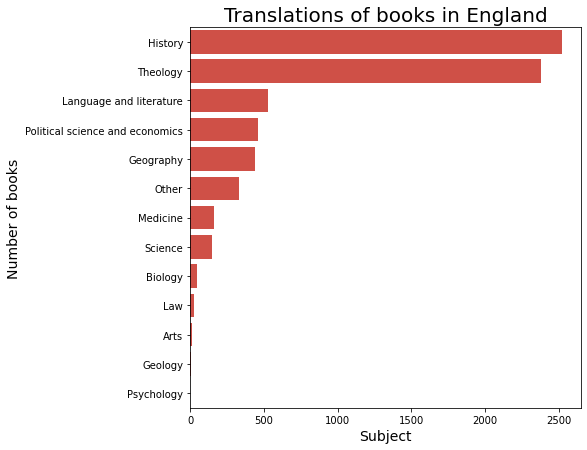

In [30]:
fig = plt.figure( figsize=( 7 , 7 ) )

x_axis = list(subjects_dict.values())
y_axis = list(subjects_dict.keys())

graph = sns.barplot( y= y_axis , x= x_axis ,  dodge=False , color = '#e63c30' )

graph.set_title('Translations of books in England' , size = 20) 
graph.set_xlabel('Subject' , size = 14) 
graph.set_ylabel('Number of books' , size = 14 )

plt.show()



## Languages

In [31]:
languages = df.drop_duplicates(['resource.value','language.value']).groupby('language.value')['resource.value'].count()
lang_dict = languages.to_dict()
for l in lang_dict:
    print( f"{Lang(l).name}: {lang_dict[l]}")

Danish: 1
German: 65
English: 41
Spanish: 1
French: 1239
Hebrew: 2
Hungarian: 1
Italian: 4
Latin: 162
Malay (macrolanguage): 1
Dutch: 4656
Polish: 4


## Publishers

In [32]:
author_names = dict()
for i,row in df.drop_duplicates('author_info.value').iterrows():
    author_names[ row['author_info.value'] ] = row['author_name.value']


authors = df.drop_duplicates(['resource.value','author_info.value']).groupby('author_info.value')['resource.value'].count()
authors_dict = authors.to_dict()
authors_dict = sortedByValue(authors_dict, ascending = False)

for author in authors_dict:
    print(f'{author} {author_names[author]} => {authors_dict[author]}')

http://data.bibliotheken.nl/id/thes/p068536283 Bunyan, John (1628-1688) => 136
http://data.bibliotheken.nl/id/thes/p068894635 Perkins, William (1558-1602) => 105
http://data.bibliotheken.nl/id/thes/p069385785 Burnet, Gilbert (1643-1715) => 94
http://data.bibliotheken.nl/id/thes/p070131325 Steele, R. (1672-1729) => 93
http://data.bibliotheken.nl/id/thes/p068241755 Purchas, Samuel (ca1577-1626) => 79
http://data.bibliotheken.nl/id/thes/p072519061 Erskine, Ralph (1685-1752) => 60
http://data.bibliotheken.nl/id/thes/p068482876 Temple (Le chevalier ; 1628-1699) => 55
http://data.bibliotheken.nl/id/thes/p069911517 Owen, John (1616-1683) => 49
http://data.bibliotheken.nl/id/thes/p072910828 Bayly, Lewis (ca.1575-1631) => 47
http://data.bibliotheken.nl/id/thes/p068369123 Defoe, Daniel (1661-1731) => 46
http://data.bibliotheken.nl/id/thes/p068929250 Henry, Matthew (1662-1714) => 43
http://data.bibliotheken.nl/id/thes/p069695776 Doddridge, Philip (1702-1751) => 42
http://data.bibliotheken.nl/id/t

In [33]:
## Francis Bacon: http://data.bibliotheken.nl/id/thes/p068482817
## Laurence Sterne: http://data.bibliotheken.nl/id/thes/p068432488
## Isaac Newton: http://data.bibliotheken.nl/id/thes/p068482841
## Daniel Defoe: http://data.bibliotheken.nl/id/thes/p068369123

translations = df[ df['author_info.value'] == 'http://data.bibliotheken.nl/id/thes/p069343233' ]

print(len(translations['printer_name.value'].unique()))

    
with open('translated_works_by_author.tsv','w',encoding='utf-8') as out:
    for i,row in translations.drop_duplicates(['resource.value']).sort_values(by='author_name.value').iterrows():
        out.write(f"{row['resource.value']} : {row['author_name.value']}\t")
        out.write(row['title.value'] + '\t')
        out.write(row['subject_label.value']+ '\t')
        out.write(row['language.value']+ '\t')
        out.write(row['publ_year.value']+ '\t')
        out.write(f"{row['printer_name.value']} \n")
    

15


## Literary authors

In [34]:
## Literary authors
 

author_names = dict()
for i,row in df.drop_duplicates('author_info.value').iterrows():
    author_names[ row['author_info.value'] ] = row['author_name.value']

df_lit = df[ df['subject_cluster'] == 'Language and literature' ]
    
authors = df_lit.drop_duplicates(['resource.value','author_info.value']).groupby('author_info.value')['resource.value'].count()
authors_dict = authors.to_dict()
authors_dict = sortedByValue(authors_dict, ascending = False)

for i, author in enumerate(authors_dict):
    print(f'{i+1}. {author} {author_names[author]} => {authors_dict[author]}')

1. http://data.bibliotheken.nl/id/thes/p068369123 Defoe, Daniel (1661-1731) => 35
2. http://data.bibliotheken.nl/id/thes/p069343233 Richardson, Samuel (1689-1761) => 26
3. http://data.bibliotheken.nl/id/thes/p068423578 Swift, Jonathan (1667-1745) => 23
4. http://data.bibliotheken.nl/id/thes/p068351771 Pope, Alexander (1688-1744) => 21
5. http://data.bibliotheken.nl/id/thes/p070131325 Steele, R. (1672-1729) => 17
6. http://data.bibliotheken.nl/id/thes/p068375018 Young, Edward (1683-1765) => 15
7. http://data.bibliotheken.nl/id/thes/p068421443 Milton, John (1608-1674) => 14
8. http://data.bibliotheken.nl/id/thes/p068403356 Fielding, Henry (1707-1754) => 12
9. http://data.bibliotheken.nl/id/thes/p06842423X Addison, J. (1672-1719) => 10
10. http://data.bibliotheken.nl/id/thes/p071770291 Sheridan, Frances (1724-1766) => 9
11. http://data.bibliotheken.nl/id/thes/p069122652 Thomson, J. (1700-1748) => 9
12. http://data.bibliotheken.nl/id/thes/p068962703 Sidney, Philip (1554-1586) => 9
13. http